# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
-   Thumbs up:  Increase the volume
-   Thumbs down: Decrease the volume
-   Left swipe: 'Jump' backwards 10 seconds
-   Right swipe: 'Jump' forward 10 seconds  
-   Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

## Objectives to Achieve

#### Generator:  
The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

#### Model: 
Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

#### Write up: 
This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

## Environment Setup and check

In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13399651308010759880
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9359555293171892406
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Importing all the important libraries

In [4]:
# Import necessary libraries, modules and instantiation
import numpy as np
import os
from skimage.io import imread
import datetime
import os
import abc
from sys import getsizeof

import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

Degrading numpy version so that it supports lstm implementation

In [5]:
import numpy as np
np.version

<module 'numpy.version' from '/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/numpy/version.py'>

In [6]:
np.__version__

'1.18.5'

We set the random seed so that the results don't vary drastically.

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

## Reading Dataset

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [8]:
project_folder='Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    image_resized=cv2.resize((self.image_height,self.image_width))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [10]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Initial Base Model

Creating a base model with Conv3D, "Relu" activation function.

In [11]:
#write your model here
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Using Batch size: 60; Epochs: 10 caused ResourceExhaustedError. Trying out with better numbers now.

### Model1 - Batch size: 10; Epochs: 1

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

In [13]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
67/67 [==============================] - 179s 3s/step - loss: 2.0746 - categorical_accuracy: 0.2766 - val_loss: 7.8463 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 7.84634, saving model to model_init_2022-05-0612_13_02.918053/model-00001-1.76668-0.34238-7.84634-0.16000.h5


#### OBSERVATION
Model has not learnt much and therefore has poor training accuracy of 27% whereas validation accuracy is of 16%

In [14]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


### Model2 - Batch Size: 20; Epochs: 25

Increasing No. of epochs and decreasing Batch size to improve model performance and decreasing GPU load.

In [15]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model()
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 80, 80, 32)   

In [16]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model)

Total Params: 1736389
Epoch 1/25
34/34 [==============================] - 56s 2s/step - loss: 1.8454 - categorical_accuracy: 0.3502 - val_loss: 3.3877 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 3.38766, saving model to model_init_2022-05-0612_16_04.406630/model-00001-1.60254-0.40724-3.38766-0.21000.h5
Epoch 2/25
34/34 [==============================] - 54s 2s/step - loss: 1.1578 - categorical_accuracy: 0.5594 - val_loss: 7.4516 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss did not improve from 3.38766
Epoch 3/25
34/34 [==============================] - 55s 2s/step - loss: 0.8662 - categorical_accuracy: 0.6773 - val_loss: 8.0925 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 3.38766
Epoch 4/25
34/34 [==============================] - 55s 2s/step - loss: 0.7113 - categorical_accuracy: 0.7319 - val_loss: 9.6394 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 3.38766
Epoch 5/25
34

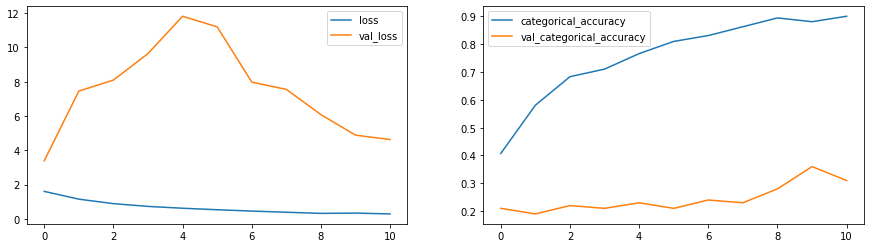

In [17]:
plot(history_model2)

#### OBSERVATION
- From above graph we can see that model is overfitting.
  1. Categorical accuracy is 90% whereas validation accuracy is 31%.
  2. Validation loss is much higher than categorical loss.
- Let's introduce regularization(dropout) technique to improve model performance.

### Model 3 - Adding Dropout

In [18]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)    

In [20]:
print("Total Params:", conv_3d4_model.count_params())
history_model3=conv_3d4.train_model(conv_3d4_model)

Total Params: 2556533
Epoch 1/25
23/23 [==============================] - 39s 2s/step - loss: 2.2094 - categorical_accuracy: 0.3040 - val_loss: 1.6461 - val_categorical_accuracy: 0.3200

Epoch 00001: val_loss improved from inf to 1.64606, saving model to model_init_2022-05-0612_26_06.710325/model-00001-1.96293-0.35596-1.64606-0.32000.h5
Epoch 2/25
23/23 [==============================] - 35s 2s/step - loss: 1.5920 - categorical_accuracy: 0.4800 - val_loss: 2.6928 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 1.64606
Epoch 3/25
23/23 [==============================] - 35s 2s/step - loss: 1.5835 - categorical_accuracy: 0.4501 - val_loss: 3.0789 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.64606
Epoch 4/25
23/23 [==============================] - 34s 2s/step - loss: 1.6229 - categorical_accuracy: 0.4505 - val_loss: 2.3751 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 1.64606
Epoch 5/25
23

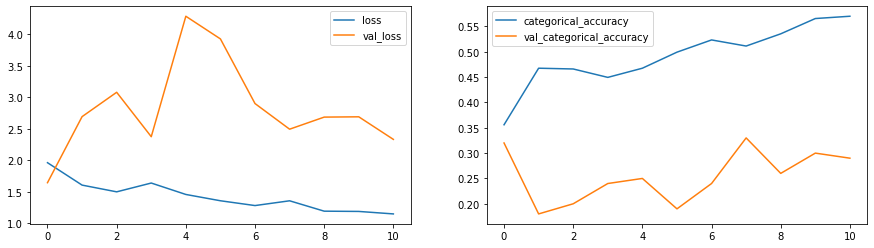

In [21]:
plot(history_model3)

#### OBSERVATION
- From above graph we can see that model is still overfitting.
  1. Difference between categorical accuracy and validation accuracy has reduced compared to previous model. However, its still not good enough.
  2. Validation loss is much higher than categorical loss. 
- Using just CNN is not showing much improvement. Let's try some RNN models along with CNN.  

### Model 4 - CNN + LSTM Model

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Let's see it helps in improving our model performance.

In [22]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [24]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model4=rnn_cnn1.train_model(rnn_cnn1_model)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 41s 1s/step - loss: 1.5430 - categorical_accuracy: 0.2986 - val_loss: 1.8872 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.88720, saving model to model_init_2022-05-0612_32_34.796837/model-00001-1.43455-0.35897-1.88720-0.21000.h5
Epoch 2/20
34/34 [==============================] - 38s 1s/step - loss: 1.0719 - categorical_accuracy: 0.5847 - val_loss: 2.0247 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.88720
Epoch 3/20
34/34 [==============================] - 38s 1s/step - loss: 0.9456 - categorical_accuracy: 0.6133 - val_loss: 2.4784 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.88720
Epoch 4/20
34/34 [==============================] - 38s 1s/step - loss: 0.7349 - categorical_accuracy: 0.7049 - val_loss: 2.2662 - val_categorical_accuracy: 0.2700

Epoch 00004: val_loss did not improve from 1.88720
Epoch 5/20
34

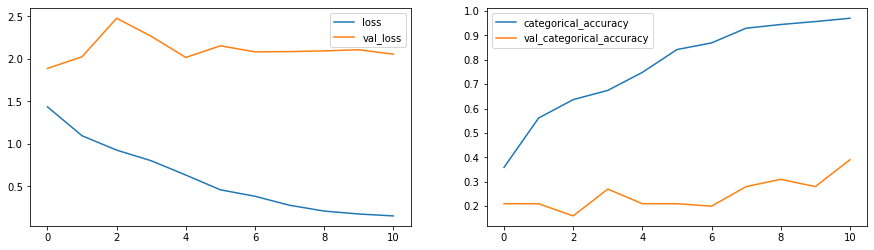

In [25]:
plot(history_model4)

#### OBSERVATION
- From above graph we can see that model is still overfitting.
  1. Difference between categorical accuracy and validation accuracy has more compared to previous model.
  2. Losses have reduced significantly compared to previous model.  

### Model 5 - CNN + LSTM + Transfer Learning

Transfer learning is a method where we reuse a pre-trained model as the starting point for a model on a new task. Including Transfer learning with LSTM and CNN to enhance model performance

In [27]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from tensorflow.keras.applications import mobilenet

In [28]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 1s 0us/step


In [29]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [30]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model5=rnn_cnn_tl.train_model(rnn_cnn_tl_model)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 35s 243ms/step - loss: 1.5419 - categorical_accuracy: 0.3288 - val_loss: 0.9932 - val_categorical_accuracy: 0.6600

Epoch 00001: val_loss improved from inf to 0.99320, saving model to model_init_2022-05-0612_41_56.369805/model-00001-1.42230-0.40573-0.99320-0.66000.h5
Epoch 2/20
133/133 [==============================] - 31s 237ms/step - loss: 0.9753 - categorical_accuracy: 0.6247 - val_loss: 0.7747 - val_categorical_accuracy: 0.7100

Epoch 00002: val_loss improved from 0.99320 to 0.77468, saving model to model_init_2022-05-0612_41_56.369805/model-00002-0.92734-0.64555-0.77468-0.71000.h5
Epoch 3/20
133/133 [==============================] - 32s 239ms/step - loss: 0.6967 - categorical_accuracy: 0.7669 - val_loss: 0.7063 - val_categorical_accuracy: 0.7500

Epoch 00003: val_loss improved from 0.77468 to 0.70629, saving model to model_init_2022-05-0612_41_56.369805/model-00003-0.67818-0.76169-0.70629-0.75000.h5
Epoc

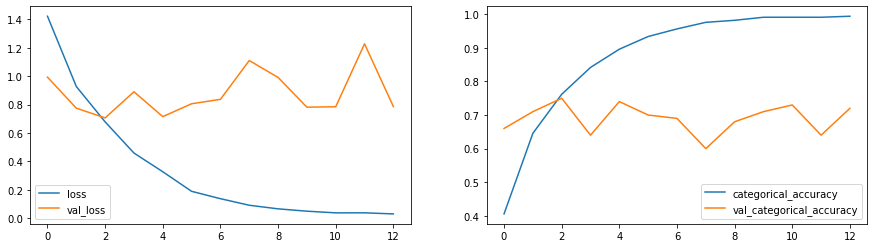

In [31]:
plot(history_model5)

#### OBSERVATION
- From above graph we can see that model has improved a lot.
  1. Difference between categorical accuracy and validation accuracy has reduced compared to previous model but could be still improved further.
  2. Difference between losses have also reduced significantly compared to previous model.
- We know GRU gives similar performance as LSTM but reduces computational time alot. Let's try GRU to improve model performance and reduce computational time which is a big factor in industry applications.

### Model 6 - CNN + GRU + Transfer Learning 

In [33]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

In [35]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model6=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - 38s 253ms/step - loss: 1.5403 - categorical_accuracy: 0.3678 - val_loss: 0.8385 - val_categorical_accuracy: 0.6300

Epoch 00001: val_loss improved from inf to 0.83845, saving model to model_init_2022-05-0612_50_42.315603/model-00001-1.30240-0.48265-0.83845-0.63000.h5
Epoch 2/20
133/133 [==============================] - 32s 244ms/step - loss: 0.8395 - categorical_accuracy: 0.6635 - val_loss: 0.6426 - val_categorical_accuracy: 0.7800

Epoch 00002: val_loss improved from 0.83845 to 0.64258, saving model to model_init_2022-05-0612_50_42.315603/model-00002-0.81846-0.67270-0.64258-0.78000.h5
Epoch 3/20
133/133 [==============================] - 32s 243ms/step - loss: 0.6005 - categorical_accuracy: 0.7990 - val_loss: 0.6362 - val_categorical_accuracy: 0.7600

Epoch 00003: val_loss improved from 0.64258 to 0.63620, saving model to model_init_2022-05-0612_50_42.315603/model-00003-0.60750-0.80090-0.63620-0.76000.h5
Epoc

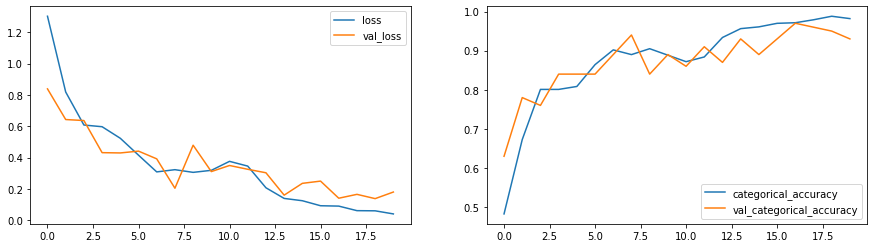

In [36]:
plot(history_model6)

#### OBSERVATION
- From above graph we can see that model has improved a bit more compared to LSTM model.
  1. Difference between categorical accuracy and validation accuracy is very less now.
  2. Losses are very low as well.
- By far its the best performing model.  

As "CNN + GRU + Tranfer Learning" model has given good performance on both train and validation data. Considering it as the final model for Gesture Recognition.

#### Note: Please refer attached document for summary of all the models in the notebook.

### Loading model and Testing

In [37]:
import time
from tensorflow.keras.models import load_model

In [39]:
model = load_model('model_init_2022-05-0612_50_42.315603/model-00019-0.05952-0.98793-0.13739-0.95000.h5')

In [40]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [41]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [42]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 1 0 2 4 3 2 2 2 3 2 1 1 4 1 3 2 2 0 1]


#### Compiled By:
1. Shivani Shrivastava
2. Rishabh Vimal